In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from tensorflow.keras.utils import to_categorical

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Subset

from torchvision.datasets import DatasetFolder

# This is for the progress bar
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

NumPy version: 1.25.2
Pandas version: 2.0.3
TensorFlow version: 2.16.1
GPU is available


In [ ]:
!pip install -q opendatasets
import os
import opendatasets as od

DATASET_PATH = od.download('https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small')


DATASET_PATH = './fashion-product-images-small'

# Check the contents of the dataset directory
print(os.listdir(DATASET_PATH))

Skipping, found downloaded files in "./fashion-product-images-small" (use force=True to force download)
['styles.csv', 'myntradataset', 'images']


In [ ]:
# Section 2: Loading the dataset
try:
    data_path = os.path.join(DATASET_PATH, "styles.csv")
    # Load the dataset, skipping bad lines with updated parameter
    data = pd.read_csv(data_path, on_bad_lines='warn')
    print("Dataset loaded successfully, potentially problematic lines noted.")
except Exception as e:
    print(f"Error loading dataset: {e}")

Dataset loaded successfully, potentially problematic lines noted.


Skipping line 6044: expected 10 fields, saw 11
Skipping line 6569: expected 10 fields, saw 11
Skipping line 7399: expected 10 fields, saw 11
Skipping line 7939: expected 10 fields, saw 11
Skipping line 9026: expected 10 fields, saw 11
Skipping line 10264: expected 10 fields, saw 11
Skipping line 10427: expected 10 fields, saw 11
Skipping line 10905: expected 10 fields, saw 11
Skipping line 11373: expected 10 fields, saw 11
Skipping line 11945: expected 10 fields, saw 11
Skipping line 14112: expected 10 fields, saw 11
Skipping line 14532: expected 10 fields, saw 11
Skipping line 15076: expected 10 fields, saw 12
Skipping line 29906: expected 10 fields, saw 11
Skipping line 31625: expected 10 fields, saw 11
Skipping line 33020: expected 10 fields, saw 11
Skipping line 35748: expected 10 fields, saw 11
Skipping line 35962: expected 10 fields, saw 11
Skipping line 37770: expected 10 fields, saw 11
Skipping line 38105: expected 10 fields, saw 11
Skipping line 38275: expected 10 fields, saw 

In [ ]:
def preprocess_and_load_data(file_path):
    corrected_lines = []  # To store corrected lines
    with open(file_path, 'r', encoding='utf-8') as file:
        for line_num, line in enumerate(file):
            fields = line.strip().split(',')
            if len(fields) == 11:  # Expected fields are 10, check if there's an extra comma
                # Attempt to merge the last two fields if it looks like a common error
                fields[-2] = fields[-2] + fields[-1]
                fields.pop()  # Remove the last item
            if len(fields) != 10:
                print(f"Line {line_num} still incorrect: {fields}")
                continue  # Skip lines that still have issues after attempted fix
            corrected_lines.append(','.join(fields))

    # Write corrected lines to a new file
    with open('corrected_dataset.csv', 'w', encoding='utf-8') as file:
        for line in corrected_lines:
            file.write(line + '\n')

    # Now load the corrected dataset
    return pd.read_csv('corrected_dataset.csv')

# Path to the original dataset
original_data_path = os.path.join(DATASET_PATH, "styles.csv")
data = preprocess_and_load_data(original_data_path)
print("Dataset loaded with preprocessing.")

Line 15075 still incorrect: ['23124', 'Unisex', 'Footwear', 'Flip Flops', 'Flip Flops', 'Navy Blue', 'Spring', '2013', 'Casual', 'Converse Unisex Navy Blue Liv', 'Laugh', 'Love Flip-flops']
Line 38403 still incorrect: ['23127', 'Unisex', 'Footwear', 'Flip Flops', 'Flip Flops', 'Green', 'Summer', '2012', 'Casual', 'Converse Unisex Green Live', ' Life', ' Laugh Flip Flops']
Dataset loaded with preprocessing.


In [ ]:
import pandas as pd

def preprocess_and_load_data(file_path):
    # Open the CSV file
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Skip the first line if it contains headers
    lines = lines[1:]  # Uncomment or adjust this if the first line of your file is the header

    # Prepare a list to hold all rows as dictionaries
    data_rows = []

    # Define the expected headers - modify this based on your actual CSV headers
    headers = ["id", "gender", "masterCategory", "subCategory", "articleType", "baseColor", "season", "year", "usage", "productDisplayName"]

    # Process each line in the CSV
    for line in lines:
        parts = line.strip().split(',')
        # Check for lines with more fields than expected
        if len(parts) > len(headers):
            # Assume extra fields are part of the last column (productDisplayName)
            parts = parts[:9] + [','.join(parts[9:])]
        # Create a dictionary for the row
        row_dict = dict(zip(headers, parts))
        data_rows.append(row_dict)

    # Create DataFrame from list of dictionaries
    data = pd.DataFrame(data_rows)
    return data

In [ ]:
# Path to the original dataset
original_data_path = os.path.join(DATASET_PATH, "styles.csv")
data = preprocess_and_load_data(original_data_path)
print("Dataset loaded with preprocessing.")

# Following the DataFrame creation, adding the 'image' column
data['image'] = data['id'].astype(str) + ".jpg"
data = data.reset_index(drop=True)

Dataset loaded with preprocessing.


In [ ]:
data.head(2)

,id,gender,masterCategory,subCategory,articleType,baseColor,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg


In [ ]:
print(data.shape)
data.info()

(44446, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44446 entries, 0 to 44445
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  44446 non-null  object
 1   gender              44446 non-null  object
 2   masterCategory      44446 non-null  object
 3   subCategory         44446 non-null  object
 4   articleType         44446 non-null  object
 5   baseColor           44446 non-null  object
 6   season              44446 non-null  object
 7   year                44446 non-null  object
 8   usage               44446 non-null  object
 9   productDisplayName  44446 non-null  object
 10  image               44446 non-null  object
dtypes: object(11)
memory usage: 3.7+ MB


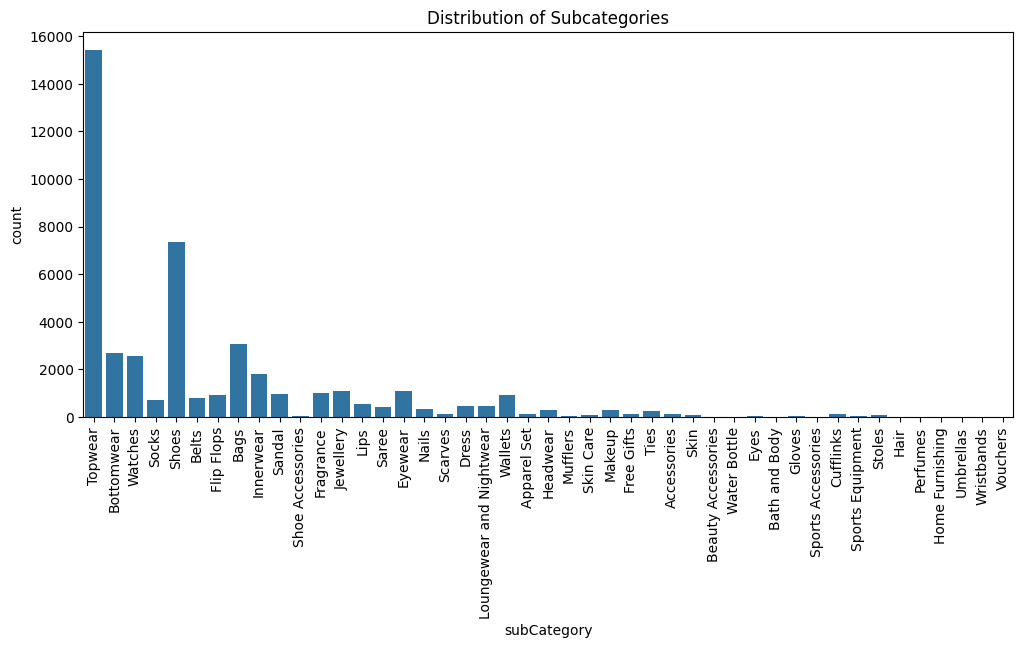

In [ ]:
# Visualize the distribution of categories - helps in understanding class imbalances
plt.figure(figsize=(12, 5))
sns.countplot(x='subCategory', data=data)
plt.title('Distribution of Subcategories')
plt.xticks(rotation=90)
plt.show()

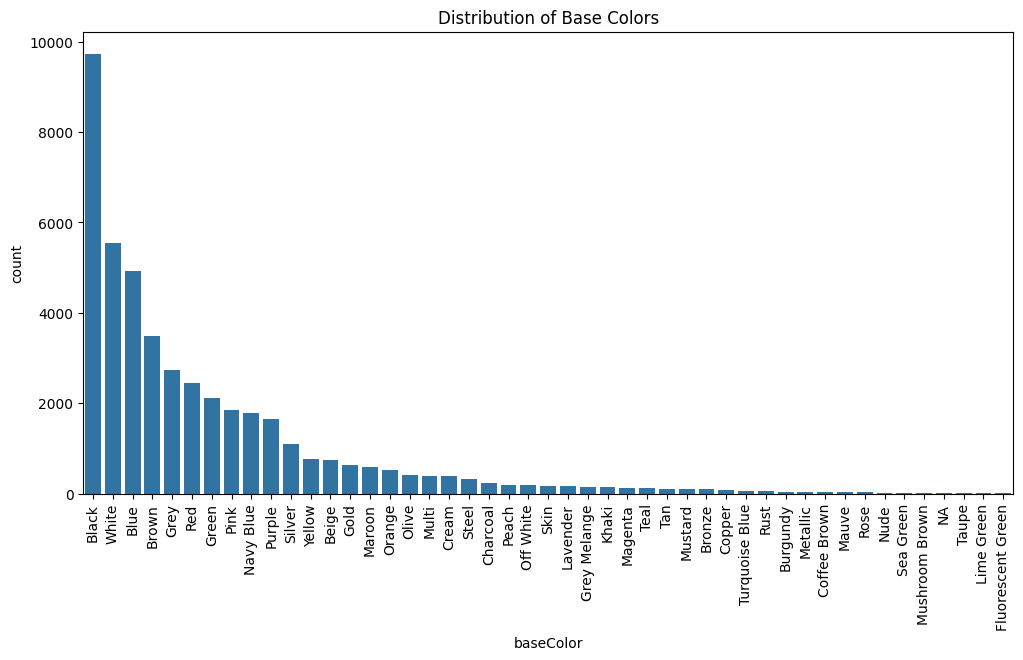

In [ ]:

# Display distribution of base colors
plt.figure(figsize=(12, 6))
sns.countplot(x='baseColor', data=data, order = data['baseColor'].value_counts().index)
plt.title('Distribution of Base Colors')
plt.xticks(rotation=90)
plt.show()

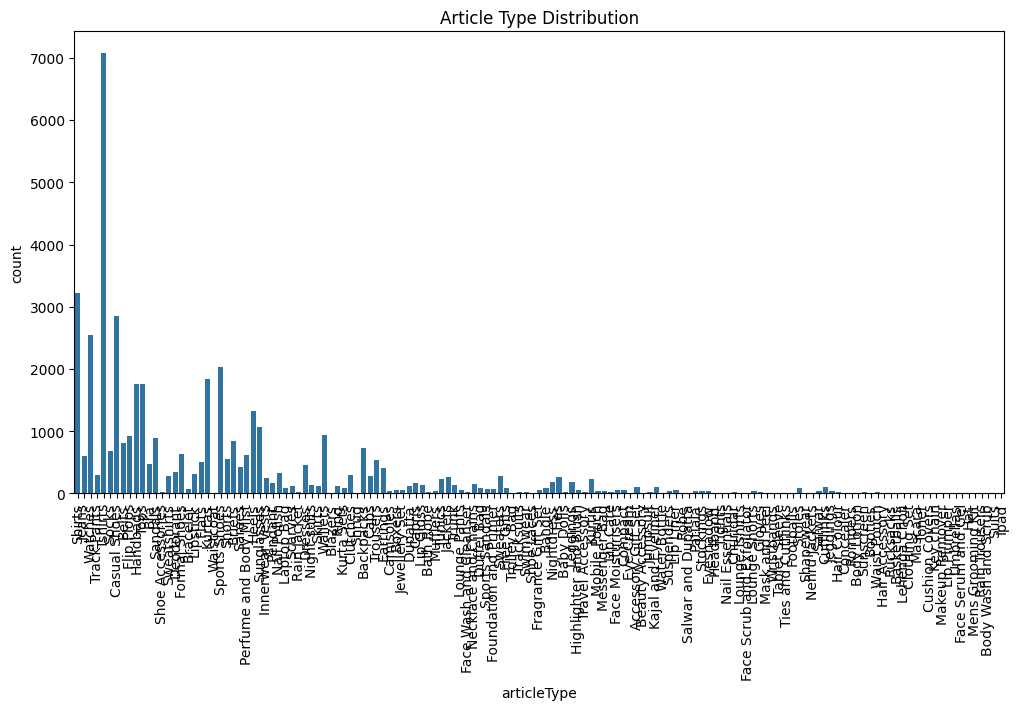

In [ ]:
# Explore the distribution of article types
plt.figure(figsize=(12, 6))
sns.countplot(x='articleType', data=data)
plt.title('Article Type Distribution')
plt.xticks(rotation=90)
plt.show()

Data Cleaning and Preprocessing


In [ ]:
# Check for any inconsistencies in categorical data
print(data['gender'].unique())
print(data['masterCategory'].unique())

# Normalize text data
data['gender'] = data['gender'].str.lower().str.strip()
data['masterCategory'] = data['masterCategory'].str.lower().str.strip()

['Men' 'Women' 'Boys' 'Girls' 'Unisex']
['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']


Data Splitting for Model Training

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into train and test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Optionally split train data further into train and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2 of original data

In [ ]:
print('train data', train_data.shape)
print('test data', test_data.shape)
print('val_data', val_data.shape)

train data (26667, 11)
test data (8890, 11)
val_data (8889, 11)


EDAbusing the Splitted Dataset

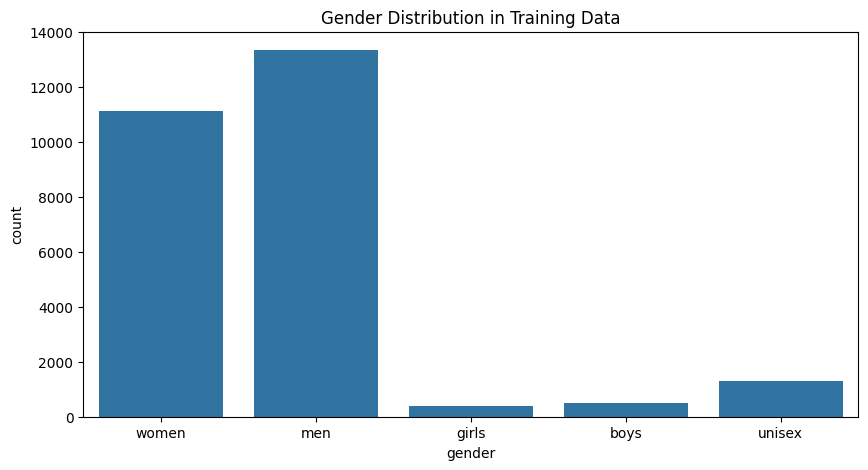

In [ ]:
# Analyze the distribution of the 'gender' category within the training data
plt.figure(figsize=(10, 5))
sns.countplot(x='gender', data=train_data)
plt.title('Gender Distribution in Training Data')
plt.show()

<ipython-input-17-5dbf47e1912d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='masterCategory', data=train_data, palette='Set2')


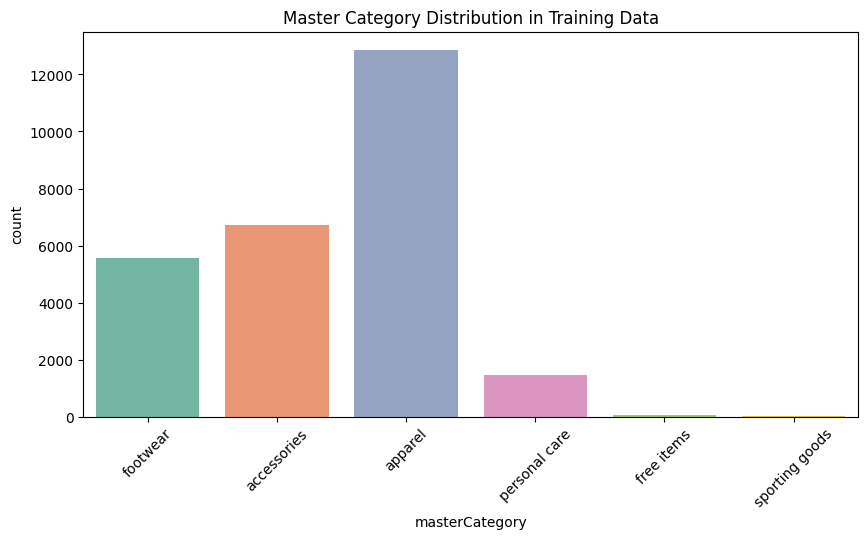

In [ ]:
# Analyze the distribution of 'masterCategory' within the training data
plt.figure(figsize=(10, 5))
sns.countplot(x='masterCategory', data=train_data, palette='Set2')
plt.title('Master Category Distribution in Training Data')
plt.xticks(rotation=45)
plt.show()

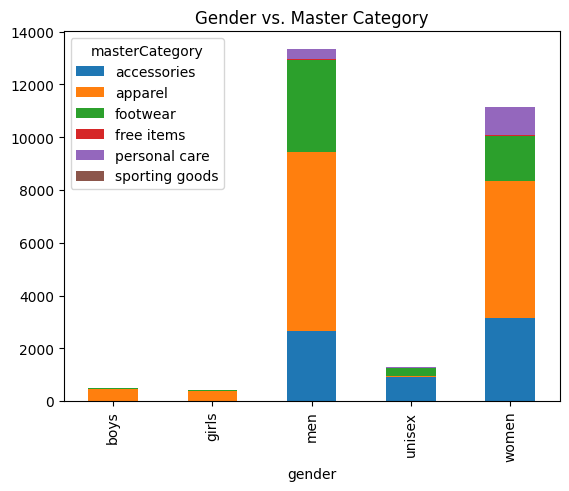

In [ ]:
# Cross-tabulation of Gender and Master Category
pd.crosstab(train_data['gender'], train_data['masterCategory']).plot(kind='bar', stacked=True)
plt.title('Gender vs. Master Category')
plt.show()

In [ ]:
# mapping between images and styles.csv
from multiprocessing import Pool

p = Pool(5)

image_name = []
for x in os.listdir(os.path.join(DATASET_PATH, 'images')):
  if os.path.isfile(os.path.join(DATASET_PATH, 'images', x)):
    image_path = os.path.join('images', x)
    image_name.append(os.path.basename(image_path))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
# convert list to integer
image_number = [i.split('.')[0] for i in image_name]
image_number = [int(i) for i in image_number]
image_number = pd.DataFrame(image_number, columns = ['id'])
image_number.head(3)

,id
0,32759
1,26908
2,11291


In [ ]:
# Use pd.concat to concatenate the dataframes correctly
df_image = pd.concat([data, image_number], axis=1)
print('Inner joint styles and images dataframe size = {}'.format(df_image.shape))

Inner joint styles and images dataframe size = (44446, 12)


In [ ]:
master_cat_name = list(df_image.groupby(['masterCategory']).groups.keys())
master_cat_name

['accessories',
 'apparel',
 'footwear',
 'free items',
 'home',
 'personal care',
 'sporting goods']

In [ ]:
# random select a image to show
sample_list = df_image.groupby(['masterCategory']).apply(lambda x: x.sample(n=5, replace=True))

samples = []
keys = []
for i in sample_list['id']:
    samples.append(i)

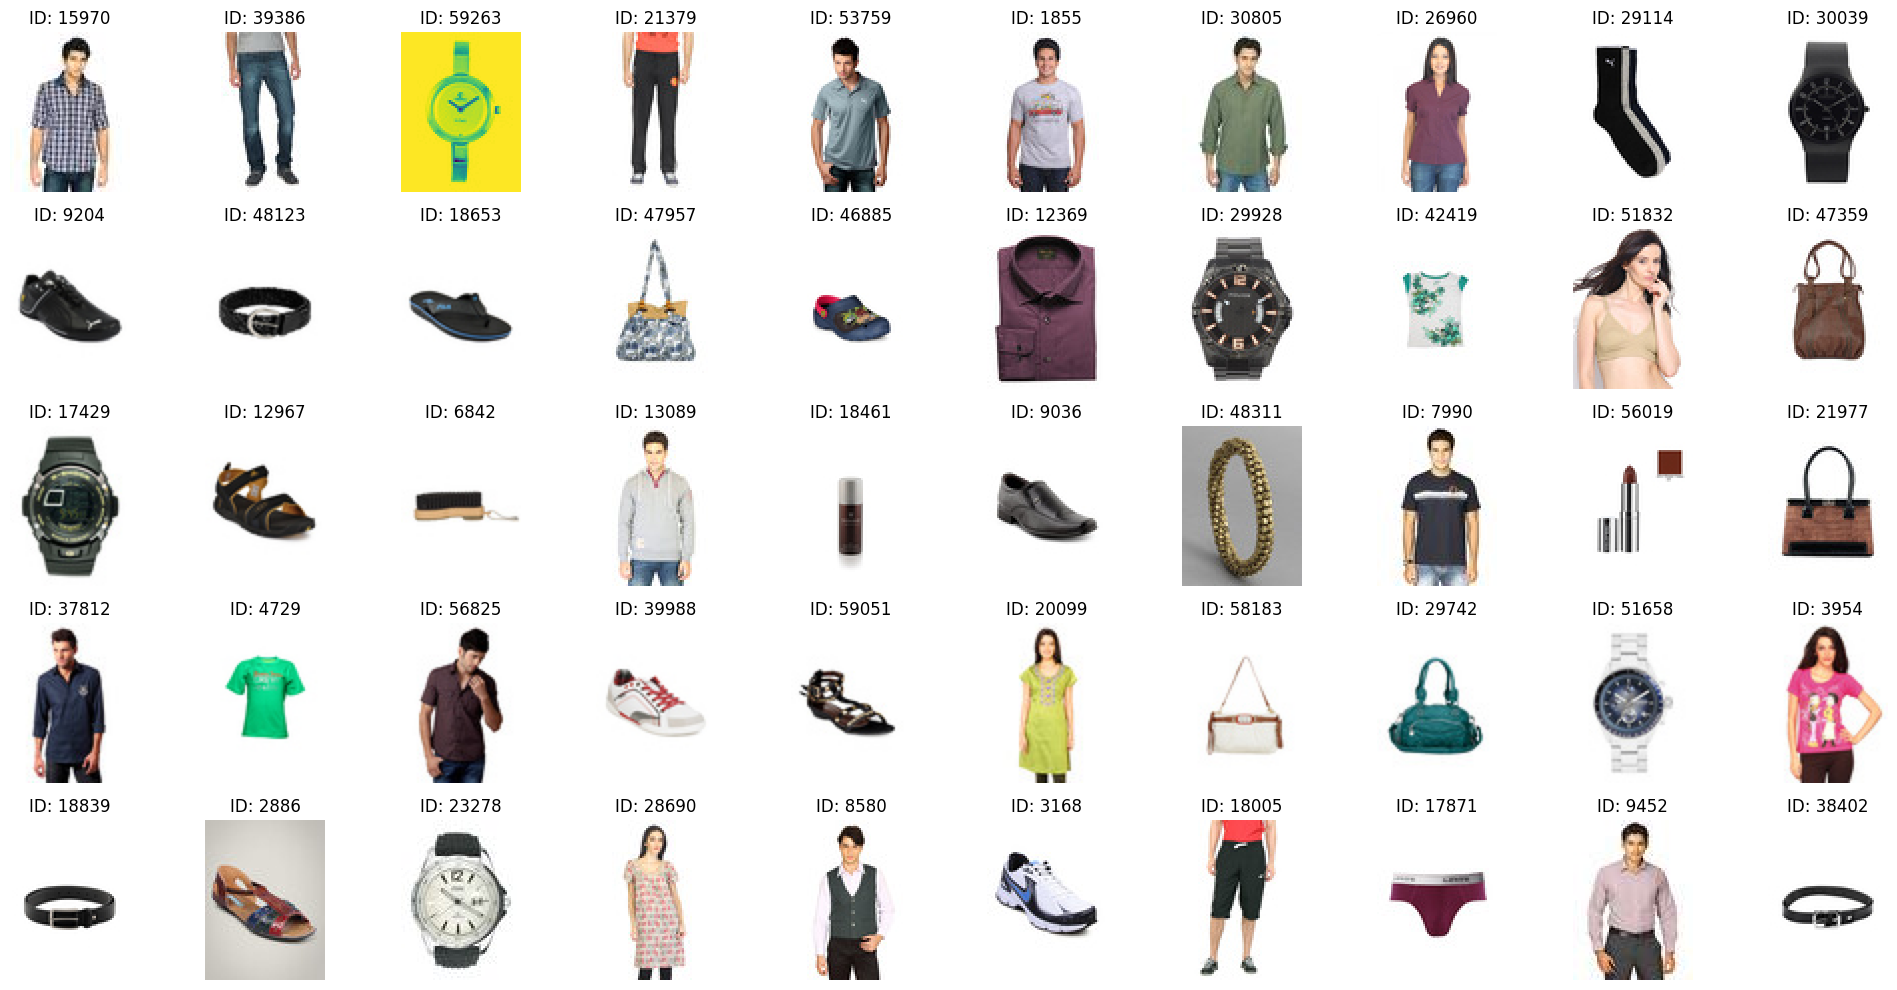

In [ ]:
import matplotlib.image as mpimg

def display_sample_images(data, number_of_images=50):
    # Calculate the number of columns and rows based on the number of images
    columns = 10
    rows = (number_of_images + columns - 1) // columns

    fig = plt.figure(figsize=(20, 2 * rows))

    for i in range(1, number_of_images + 1):
        if i <= len(data):
            image_id = data.iloc[i-1]['id']
            image_path = os.path.join(DATASET_PATH, 'images', f"{image_id}.jpg")
            try:
                img = mpimg.imread(image_path)
                ax = fig.add_subplot(rows, columns, i)
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f"ID: {image_id}")
            except FileNotFoundError:
                print(f"Image file not found: {image_path}")
        else:
            break
    plt.tight_layout()
    plt.show()

display_sample_images(data)

In [ ]:
# Filter out rows where the image file is missing
missing_ids = ['39403', '39410', '39401', '39425', '12347']
data = data[~data['id'].isin(missing_ids)]

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os

def create_placeholder_image(target_size=(128, 128)):
    return np.zeros((target_size[0], target_size[1], 3))  # Creates a black image of the specified size

def preprocess_images_with_placeholder(data, image_column, target_size=(128, 128)):
    image_data = []
    for image_name in data[image_column]:
        image_path = os.path.join(DATASET_PATH, 'images', image_name)
        if os.path.exists(image_path):
            image = load_img(image_path, target_size=target_size)
            image_array = img_to_array(image)
        else:
            image_array = create_placeholder_image(target_size)  # Use placeholder for missing images
        image_data.append(image_array)
    return np.array(image_data)

# Process the images with placeholders for missing ones
X = preprocess_images_with_placeholder(data, 'image')

In [ ]:
X = X / 255.0  # Normalize image data to [0, 1]


from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(data['masterCategory'])

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and temp sets (temp will be split into test and validation)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)

Model Training and Evaluation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
# Define the CNN architecture
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')  # Output layer with 7 classes
])

# Compile the model
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model to check the architecture
model_cnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,543 (12.61 MB)

 Trainable params: 3,305,543 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_cnn.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))

Epoch 1/25
834/834 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.8776 - loss: 0.3751 - val_accuracy: 0.9622 - val_loss: 0.1373
Epoch 2/25
834/834 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9718 - loss: 0.0979 - val_accuracy: 0.9647 - val_loss: 0.1321
Epoch 3/25
834/834 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9835 - loss: 0.0600 - val_accuracy: 0.9783 - val_loss: 0.0888
Epoch 4/25
834/834 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9889 - loss: 0.0407 - val_accuracy: 0.9833 - val_loss: 0.0803
Epoch 5/25
834/834 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9935 - loss: 0.0245 - val_accuracy: 0.9800 - val_loss: 0.0987
Epoch 6/25
834/834 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9941 - loss: 0.0186 - val_accuracy: 0.9800 - val_loss: 0.1065
Epoch 7/25
834/834 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9963 - loss: 0.0122 - val_accuracy: 0.9772 - val_loss: 0.1373
Epoch 8/25
834/834 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9946 - loss: 0.0167 - 

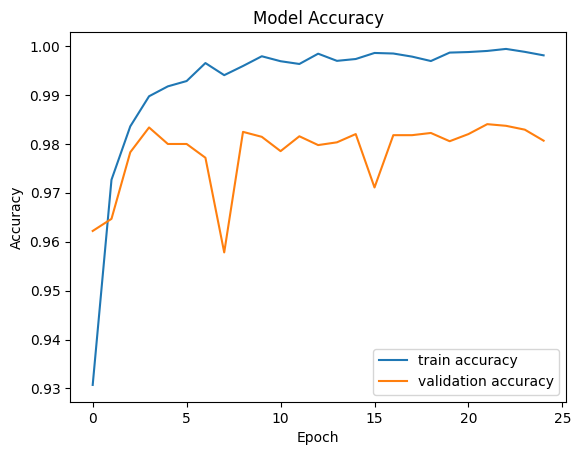

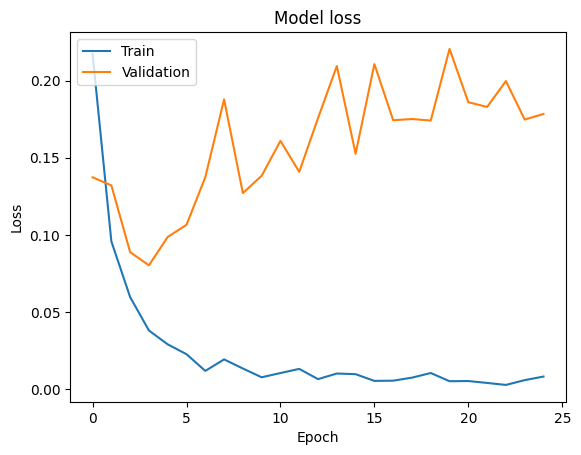

In [ ]:
# Plot training and validation accuracy

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model_cnn.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9818 - loss: 0.1571
Test Loss: 0.145014226436615, Test Accuracy: 0.98211270570755


The model shows a good performance but also shows a sign of overfitting. We are going to use a keras tuner to fine tune the cnn model.

In [ ]:
import kerastuner as kt
from tensorflow.keras.layers import Dropout

def build_model(hp):
    model = Sequential([
        Conv2D(
            filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
            activation='relu',
            input_shape=(128, 128, 3)
        ),
        MaxPooling2D(2, 2),
        Conv2D(
            filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
            activation='relu'
        ),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(
            units=hp.Int('units', min_value=100, max_value=500, step=100),
            activation='relu'
        ),
        Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
        Dense(7, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

<ipython-input-34-1e632020dd1f>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='model_tuning',
    project_name='fashion_classification'
)

# Callback to stop early if the validation loss does not improve
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Execute the search
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[stop_early])

Reloading Tuner from model_tuning/fashion_classification/tuner0.json


In [ ]:
# Get the best hyperparameters.
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best number of filters in the first Conv layer: {best_hps.get('filters_1')}")
print(f"Best kernel size for the first Conv layer: {best_hps.get('kernel_size_1')}")
print(f"Best number of filters in the second Conv layer: {best_hps.get('filters_2')}")
print(f"Best kernel size for the second Conv layer: {best_hps.get('kernel_size_2')}")
print(f"Best number of units in the Dense layer: {best_hps.get('units')}")
print(f"Best dropout rate: {best_hps.get('dropout')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

Best number of filters in the first Conv layer: 32
Best kernel size for the first Conv layer: 5
Best number of filters in the second Conv layer: 96
Best kernel size for the second Conv layer: 3
Best number of units in the Dense layer: 500
Best dropout rate: 0.2
Best learning rate: 0.00016002789506967393


In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Physical devices cannot be modified after being initialized


In [ ]:
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Data type:", X_train.dtype)
print("Label type:", y_train.dtype)
print("Data range:", X_train.min(), X_train.max())

Training data shape: (26664, 128, 128, 3)
Training labels shape: (26664,)
Data type: float32
Label type: int64
Data range: 0.0 1.0


In [ ]:
tune_model_cnn = build_model(best_hps)
tune_model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(tune_model_cnn.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 124, 124, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 60, 60, 96)          │          27,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 500)                 │      43,200,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,234,183 (164.93 MB)

 Trainable params: 43,234,183 (164.93 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set at program startup
        print(e)

Physical devices cannot be modified after being initialized


In [ ]:
history = tune_model_cnn.fit(
        X_train,
        y_train,
        epochs=25,
        validation_data=(X_val, y_val),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
    )

Epoch 1/25
834/834 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.8759 - loss: 0.6286 - val_accuracy: 0.9568 - val_loss: 0.1614
Epoch 2/25
834/834 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9596 - loss: 0.1307 - val_accuracy: 0.9737 - val_loss: 0.1024
Epoch 3/25
834/834 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9837 - loss: 0.0615 - val_accuracy: 0.9731 - val_loss: 0.1064
Epoch 4/25
834/834 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9894 - loss: 0.0384 - val_accuracy: 0.9714 - val_loss: 0.1332
Epoch 5/25
834/834 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9913 - loss: 0.0323 - val_accuracy: 0.9766 - val_loss: 0.1384
Epoch 6/25
834/834 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9961 - loss: 0.0172 - val_accuracy: 0.9759 - val_loss: 0.1252
Epoch 7/25
834/834 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9957 - loss: 0.0129 - val_accuracy: 0.9732 - val_loss: 0.1594
Epoch 8/25
834/834 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9963 - loss: 0.0193 - 

In [ ]:
test_loss, test_accuracy = tune_model_cnn.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9793 - loss: 0.1425
Test Loss: 0.13715483248233795, Test Accuracy: 0.9799752235412598


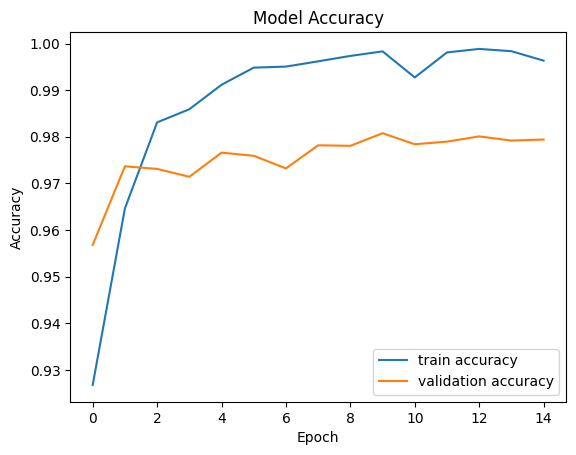

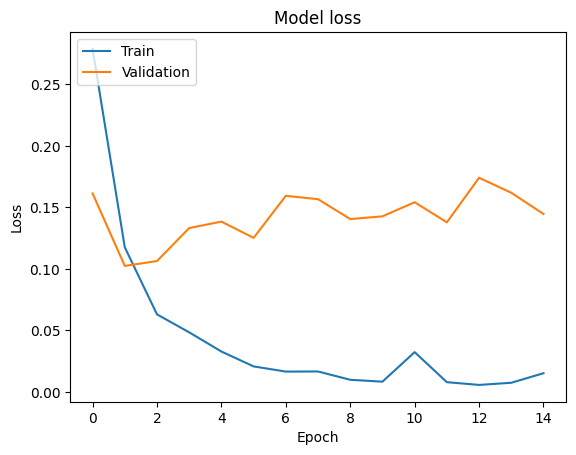

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Assume `y_test` are your true labels and `y_pred` are the model's predictions
y_pred = tune_model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Calculating the various metrics
print("Accuracy:", accuracy_score(y_test, y_pred_classes))
print("Precision:", precision_score(y_test, y_pred_classes, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_classes, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_classes, average='weighted'))

# Detailed classification report
print(classification_report(y_test, y_pred_classes))

278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 0.9799752503093712
Precision: 0.9788539668869727
Recall: 0.9799752503093712
F1-Score: 0.9793115678731528
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2246
           1       0.99      0.99      0.99      4281
           2       0.99      0.99      0.99      1883
           3       0.00      0.00      0.00        13
           5       0.96      0.93      0.95       459
           6       1.00      0.43      0.60         7

    accuracy                           0.98      8889
   macro avg       0.82      0.72      0.75      8889
weighted avg       0.98      0.98      0.98      8889



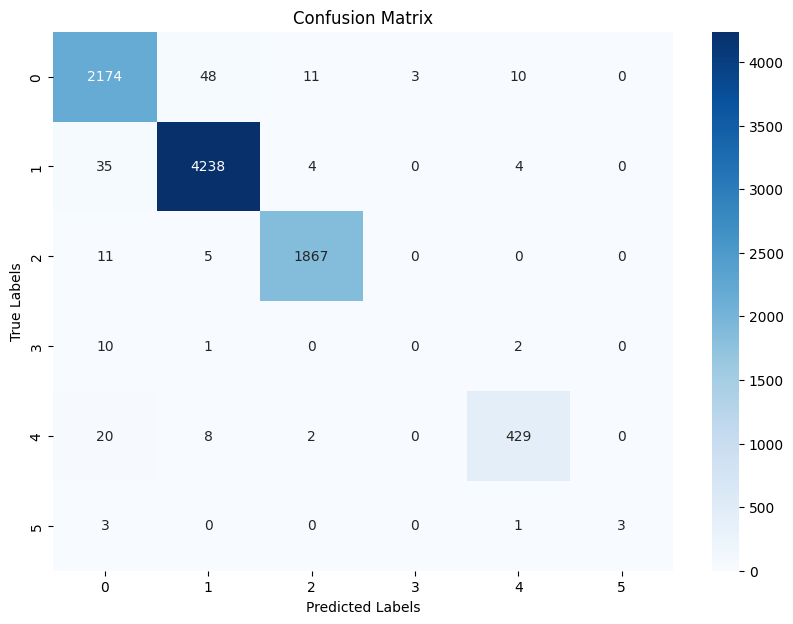

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plotting using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

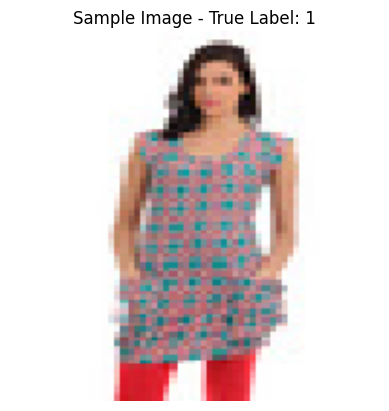

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
Predicted label: [1]


In [ ]:
index = np.random.randint(0, len(X_test))  # Randomly select an index or set it to a specific number
sample_image = X_test[index]
true_label = y_test[index]

# Display the image
plt.imshow(sample_image)
plt.title(f"Sample Image - True Label: {true_label}")
plt.axis('off')
plt.show()

# Model prediction
sample_image_batch = np.expand_dims(sample_image, axis=0)
predicted_scores = tune_model_cnn.predict(sample_image_batch)
predicted_label = np.argmax(predicted_scores, axis=1)

print(f"Predicted label: {predicted_label}")

In [ ]:
# Access the input shape directly from the model
input_shape = tune_model_cnn.input_shape

# Print the input shape
print("Input shape of the model:", input_shape)

Input shape of the model: (None, 128, 128, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


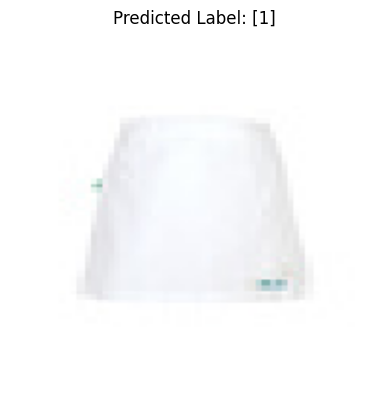

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Path to your image file
image_path = '/content/fashion-product-images-small/images/10000.jpg'
image = load_img(image_path, target_size=(128, 128))  # Adjust target_size to match your model's input shape
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)  # Model expects a batch of images
image_array /= 255.0  # Normalization, if applied in your model

# Predict using your model
predicted_scores = model_cnn.predict(image_array)
predicted_label = np.argmax(predicted_scores, axis=1)

# Display the image and prediction
plt.imshow(image)
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()
